In [1]:
from tensorflow import keras
import json
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import dataset
from util import (
    get_place_to_index_mapping,
    get_incident_to_index_mapping
)
from keras.applications.resnet50 import ResNet50
from keras.layers import Dense, Flatten
from keras import Sequential
import keras.backend as kb
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
import PIL

In [2]:
abs_path = "/kuacc/users/asafaya19/cv-project"
train_json = os.path.join(abs_path ,"eccv_train.json")
val_json = os.path.join(abs_path ,"eccv_val.json")
data_dir = os.path.join(abs_path, "data")
train_dir = os.path.join(data_dir, "train")
val_dir = os.path.join(data_dir, "val")

In [3]:
train_paths = json.loads(open(train_json).readline())
val_paths = json.loads(open(val_json).readline())

In [4]:
place_to_idx = get_place_to_index_mapping()
incident_to_idx = get_incident_to_index_mapping()

In [6]:
def get_dataset(paths,file_dir, threshold=1000):
    train_set = []
    for path in tqdm(paths, leave=False):
    #     print(path)
        if not os.path.exists(os.path.join(file_dir, path)):
            continue
        # Make sure image is not corrupt, try importing it
        try:
            PIL.Image.open(os.path.join(file_dir, path))
        except:
            continue
        nump = len(place_to_idx)+1
        numi = len(incident_to_idx)+1
        place_labels = np.zeros(nump, np.float32)
        place_weights = np.zeros(nump, np.float32)
        incident_labels = np.zeros(numi, np.float32)
        incident_weights = np.zeros(numi, np.float32)

        incidents = paths[path]["incidents"]
        for k in incidents:
            lbl = incidents[k]
            if lbl==1:
                # We are sure this instance is only this incident
                incident_labels[incident_to_idx[k]]=1
                incident_weights = np.ones(numi, np.float32)
            else:
                # We are only sure that this image is not that incident
                incident_weights[incident_to_idx[k]]=1
        if len(incidents)==0:
            # No incident
            incident_labels[-1]=1
            incident_weights = np.ones(numi, np.float32)

        places = paths[path]["places"]
        for k in places:
            lbl = places[k]
            if lbl==1:
                # We are sure this instance is only this incident
                place_labels[place_to_idx[k]]=1
                place_weights = np.ones(nump, np.float32)
            else:
                # We are only sure that this image is not that incident
                place_weights[place_to_idx[k]]=1
        if len(places)==0:
            # No place
            place_labels[-1]=1
            place_weights = np.ones(nump, np.float32)


        train_set.append({
            "path":path,
            "incident_labels":incident_labels,
            "incident_weights":incident_weights,
            "incidents":np.vstack((incident_labels, incident_weights)),
            "place_labels":place_labels,
            "place_weights":place_weights,
            "place":np.vstack((place_labels, place_weights))
        })
        if len(train_set)>=threshold:
            break
    return train_set

In [7]:
train_set = get_dataset(train_paths, train_dir, 1000)
val_set = get_dataset(val_paths, val_dir, 1000)

In [8]:
train_df = pd.DataFrame(train_set)
val_df = pd.DataFrame(val_set)

In [218]:
?ImageDataGenerator

In [234]:
?keras.layers.experimental.preprocessing.RandomCrop

In [9]:
def getpreprocessfunc():
    mean = np.asarray([0.485, 0.456, 0.406]).reshape(1, 1, 3).astype(np.float32)
    std = np.asarray([0.229, 0.224, 0.225]).reshape(1, 1, 3).astype(np.float32)
    def preprocessfunc(img):
        img /= 255
        img -= mean
        img /= std
        return img
    return preprocessfunc


In [25]:
imgen = ImageDataGenerator(
    horizontal_flip=True,
    preprocessing_function=getpreprocessfunc(),
)

imgen = imgen.flow_from_dataframe(
    train_df,
    directory=train_dir,
    x_col="path",
    y_col=["incidents", "place"],
    weight_col=None,
    target_size=(256, 256),
    color_mode="rgb",
    classes=None,
    class_mode="multi_output",
    batch_size=64,
    shuffle=False,
    seed=True,
    save_to_dir=None,
    save_prefix="",
    save_format="png",
    subset=None,
    interpolation="nearest",
    validate_filenames=True,
)

Found 1000 validated image filenames.


In [239]:
nxt = next(imgen)

In [119]:
a = np.asarray([1, 0, 0, 0, 0, 0]).astype(np.float32)
b = np.vstack((a*10, a))#np.asarray([[1, 0, 0, 0, 0, 0], [1, 0, 0, 0, 0]])

In [121]:
keras.losses.BinaryCrossentropy()(a, a)

<tf.Tensor: shape=(), dtype=float32, numpy=-0.0>

In [120]:
weighted_loss(b.reshape((1, 2, 6)), a.reshape((1, 6)))

<tf.Tensor: shape=(), dtype=float32, numpy=-0.870167>

In [26]:
inp = keras.Input(shape=(256, 256, 3))

In [27]:
cropped = keras.layers.experimental.preprocessing.RandomCrop(224, 224)(inp)

In [28]:
model = ResNet50(include_top=False, pooling = "avg")(cropped)

In [29]:
trunk = Dense(1024, activation="relu", name="trunk")(model)

In [30]:
incident_proj = Dense(len(incident_to_idx)+1, name="incidents_projection")(trunk)

In [31]:
places_proj = Dense(len(place_to_idx)+1, name="places_projection")(trunk)

In [40]:
# Enclosure to retain state
def get_weighted_accuracy():
    m = keras.metrics.CategoricalAccuracy()
    def weighted_accuracy(y_true, y_preds):
        y_true = tf.reshape(y_true, (bs, 2, -1))
        y_true_lbls = y_true[:,0,:]
        return m(y_true_lbls, y_preds)
    return weighted_accuracy

In [41]:
def weighted_loss(y_true, y_preds):
    bce = keras.losses.BinaryCrossentropy(keras.losses.Reduction.NONE)
#     tf.print(y_true)
#     tf.print(y_preds)
#     print(y_true.shape)
#     print(y_preds.shape)
    bs = y_true.shape[0]
    y_true = tf.reshape(y_true, (bs, 2, -1))
    y_true_lbls = y_true[:,0,:]
    y_true_weights = y_true[:,1,:]
    bce_loss = bce(y_true_lbls, y_preds)
#     import pdb
#     pdb.set_trace()
    return bce_loss
#     return tf.reduce_sum(tf.multiply(bce_loss, y_true_weights))

In [42]:
mdl = keras.Model(inputs=inp, outputs=[incident_proj, places_proj])

In [43]:
losses = {
    "incidents_projection": weighted_loss,
    "places_projection": weighted_loss,
}

In [44]:
opt = keras.optimizers.Adam(lr=1e-5)

In [45]:
mdl.compile(optimizer=opt, loss=losses, metrics=[get_weighted_accuracy()])

In [ ]:
# itr = tqdm(imgen)
for x, y in imgen:
#     print(type(x), type(y))
    y1 = y[0]
    y2 = y[1]
    bs = y1.shape[0]
    print(mdl.train_on_batch(x, [y1.reshape(bs, -1), y2.reshape(bs, -1)], return_dict=True), "\r")
#     break

{'loss': 0.05775917321443558, 'incidents_projection_loss': 0.030211426317691803, 'places_projection_loss': 0.027547746896743774, 'incidents_projection_weighted_accuracy': 0.140625, 'places_projection_weighted_accuracy': 0.40625} 
{'loss': 0.06510251015424728, 'incidents_projection_loss': 0.03755028173327446, 'places_projection_loss': 0.027552226558327675, 'incidents_projection_weighted_accuracy': 0.3333333432674408, 'places_projection_weighted_accuracy': 0.40234375} 
{'loss': 0.05388979613780975, 'incidents_projection_loss': 0.028900669887661934, 'places_projection_loss': 0.02498912811279297, 'incidents_projection_weighted_accuracy': 0.36250001192092896, 'places_projection_weighted_accuracy': 0.4166666567325592} 
{'loss': 0.0698065534234047, 'incidents_projection_loss': 0.03945020213723183, 'places_projection_loss': 0.030356353148818016, 'incidents_projection_weighted_accuracy': 0.390625, 'places_projection_weighted_accuracy': 0.41796875} 
{'loss': 0.04725120589137077, 'incidents_proje

{'loss': 0.05128232389688492, 'incidents_projection_loss': 0.029652312397956848, 'places_projection_loss': 0.02163001336157322, 'incidents_projection_weighted_accuracy': 0.41555342078208923, 'places_projection_weighted_accuracy': 0.41870301961898804} 
{'loss': 0.043185826390981674, 'incidents_projection_loss': 0.02339712530374527, 'places_projection_loss': 0.019788701087236404, 'incidents_projection_weighted_accuracy': 0.41620370745658875, 'places_projection_weighted_accuracy': 0.42016422748565674} 
{'loss': 0.05802939832210541, 'incidents_projection_loss': 0.0337715670466423, 'places_projection_loss': 0.024257829412817955, 'incidents_projection_weighted_accuracy': 0.4179406464099884, 'places_projection_weighted_accuracy': 0.4204343855381012} 
{'loss': 0.03959723562002182, 'incidents_projection_loss': 0.023255547508597374, 'places_projection_loss': 0.016341686248779297, 'incidents_projection_weighted_accuracy': 0.4176136255264282, 'places_projection_weighted_accuracy': 0.42176723480224

{'loss': 0.038009416311979294, 'incidents_projection_loss': 0.02022455632686615, 'places_projection_loss': 0.017784859985113144, 'incidents_projection_weighted_accuracy': 0.4296875, 'places_projection_weighted_accuracy': 0.43165552616119385} 
{'loss': 0.052212752401828766, 'incidents_projection_loss': 0.030914824455976486, 'places_projection_loss': 0.02129792980849743, 'incidents_projection_weighted_accuracy': 0.4301609992980957, 'places_projection_weighted_accuracy': 0.43150845170021057} 
{'loss': 0.03409624472260475, 'incidents_projection_loss': 0.019989196211099625, 'places_projection_loss': 0.014107048511505127, 'incidents_projection_weighted_accuracy': 0.43003731966018677, 'places_projection_weighted_accuracy': 0.4321759343147278} 
{'loss': 0.036930594593286514, 'incidents_projection_loss': 0.021614477038383484, 'places_projection_loss': 0.01531611755490303, 'incidents_projection_weighted_accuracy': 0.4302619397640228, 'places_projection_weighted_accuracy': 0.4324817657470703} 
{'

{'loss': 0.04664388298988342, 'incidents_projection_loss': 0.02702883817255497, 'places_projection_loss': 0.019615046679973602, 'incidents_projection_weighted_accuracy': 0.4423200488090515, 'places_projection_weighted_accuracy': 0.4431745409965515} 
{'loss': 0.02882087230682373, 'incidents_projection_loss': 0.016901463270187378, 'places_projection_loss': 0.011919409036636353, 'incidents_projection_weighted_accuracy': 0.442191481590271, 'places_projection_weighted_accuracy': 0.44359177350997925} 
{'loss': 0.03209936246275902, 'incidents_projection_loss': 0.019453998655080795, 'places_projection_loss': 0.012645363807678223, 'incidents_projection_weighted_accuracy': 0.4423016309738159, 'places_projection_weighted_accuracy': 0.44376567006111145} 
{'loss': 0.03023730218410492, 'incidents_projection_loss': 0.01914907805621624, 'places_projection_loss': 0.011088225059211254, 'incidents_projection_weighted_accuracy': 0.44311097264289856, 'places_projection_weighted_accuracy': 0.444168746471405

{'loss': 0.025403061881661415, 'incidents_projection_loss': 0.014967501163482666, 'places_projection_loss': 0.010435560718178749, 'incidents_projection_weighted_accuracy': 0.45197877287864685, 'places_projection_weighted_accuracy': 0.4530048072338104} 
{'loss': 0.026303723454475403, 'incidents_projection_loss': 0.015882469713687897, 'places_projection_loss': 0.010421253740787506, 'incidents_projection_weighted_accuracy': 0.4521671533584595, 'places_projection_weighted_accuracy': 0.4533635377883911} 
{'loss': 0.02745186537504196, 'incidents_projection_loss': 0.01767541840672493, 'places_projection_loss': 0.009776447899639606, 'incidents_projection_weighted_accuracy': 0.4529467821121216, 'places_projection_weighted_accuracy': 0.45371684432029724} 
{'loss': 0.03492195904254913, 'incidents_projection_loss': 0.0234068650752306, 'places_projection_loss': 0.011515092104673386, 'incidents_projection_weighted_accuracy': 0.45330187678337097, 'places_projection_weighted_accuracy': 0.4537711441516

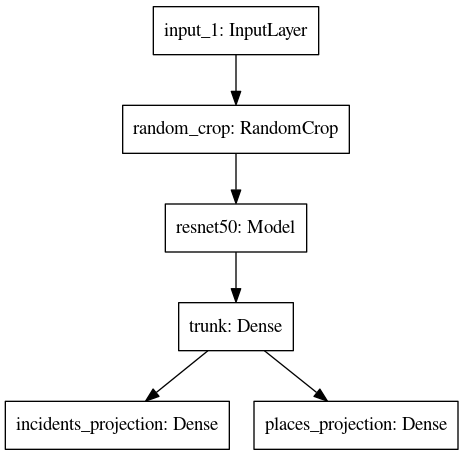

In [21]:
keras.utils.plot_model(mdl)

In [39]:
mdl.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
random_crop_1 (RandomCrop)      (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
resnet50 (Model)                (None, 2048)         23587712    random_crop_1[0][0]              
__________________________________________________________________________________________________
trunk (Dense)                   (None, 1024)         2098176     resnet50[1][0]                   
____________________________________________________________________________________________